In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from tqdm import tqdm
import random

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, _), (test_images, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
latent_dims = [2, 4, 8, 16, 32, 64]
num_images_to_display = 5
random_indices = random.sample(range(len(test_images)), num_images_to_display)

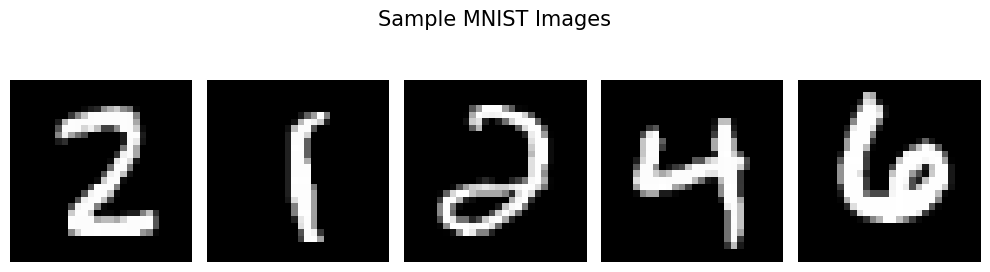

In [ ]:
plt.figure(figsize=(10, 3))
plt.suptitle("Sample MNIST Images", fontsize=15)

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(test_images[idx], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Flatten the images
train_images_flat = train_images.reshape(-1, 28*28)
test_images_flat = test_images.reshape(-1, 28*28)

In [ ]:
# Standardize the data
train_images_flat_std = (train_images_flat - np.mean(train_images_flat)) / np.std(train_images_flat)
test_images_flat_std = (test_images_flat - np.mean(train_images_flat)) / np.std(train_images_flat)

## Part A: Principal Component Analysis

In [ ]:
reconstructed_images = {}
for latent_dim in latent_dims:
    # Fit PCA
    pca = PCA(n_components=latent_dim)
    pca.fit(train_images_flat_std)

    # Transform and inverse transform
    transformed_data = pca.transform(test_images_flat_std)
    reconstructed_data = pca.inverse_transform(transformed_data)
    reconstructed_images[latent_dim] = reconstructed_data.reshape(-1, 28, 28)

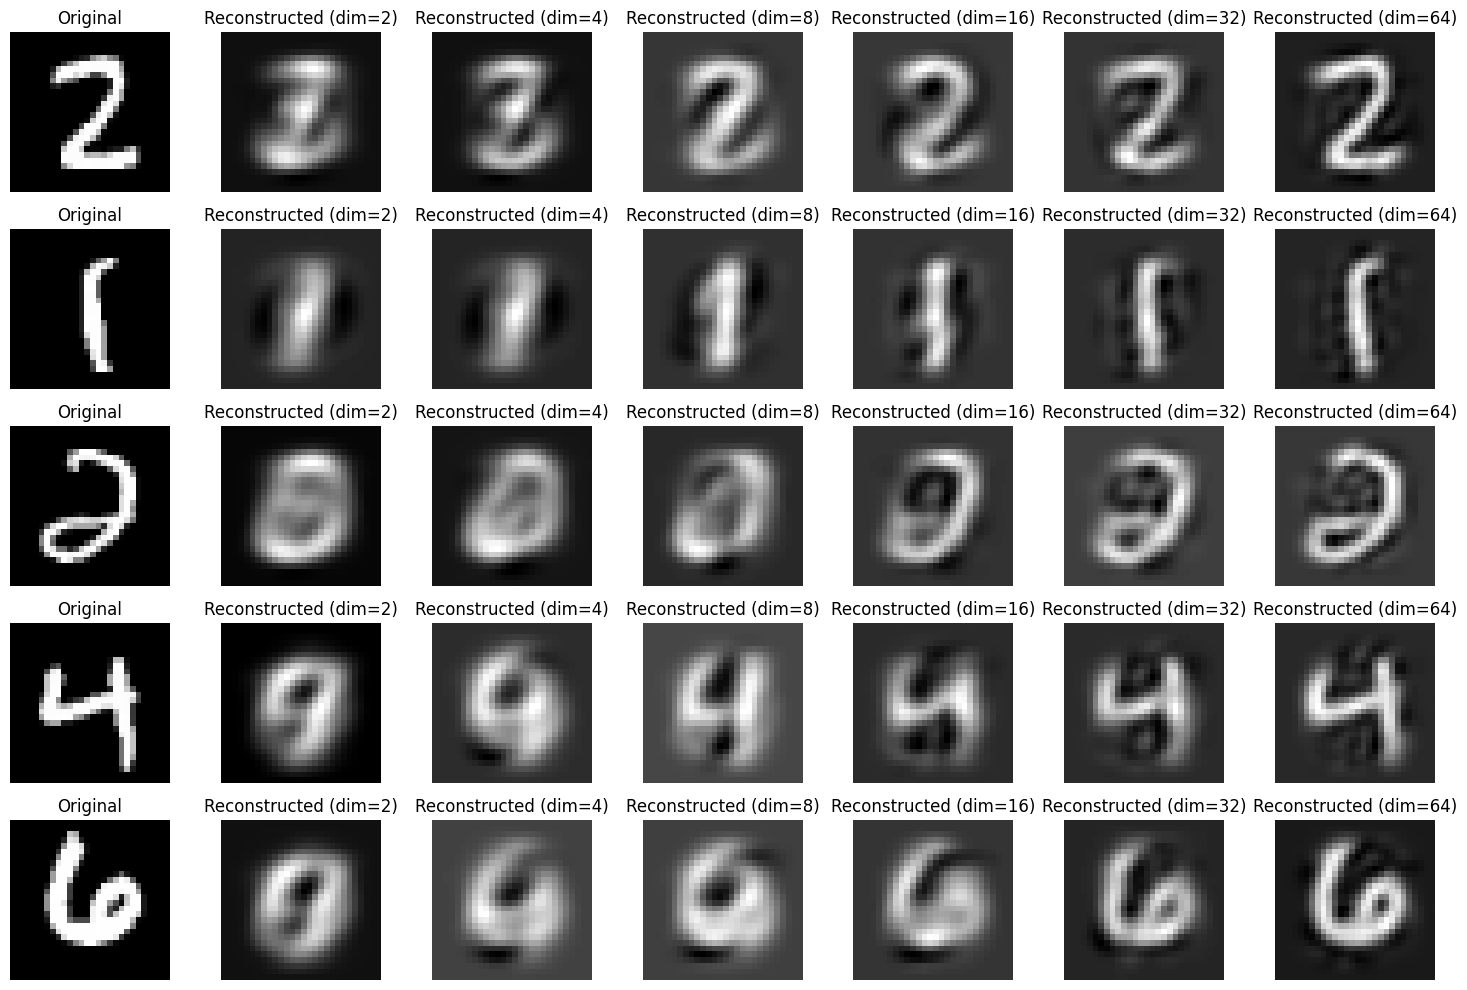

In [ ]:
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(num_images_to_display, len(latent_dims) + 1, i * (len(latent_dims) + 1) + 1)
    plt.imshow(test_images[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(num_images_to_display, len(latent_dims) + 1, i * (len(latent_dims) + 1) + j + 2)
        plt.imshow(reconstructed_images[latent_dim][idx], cmap='gray')
        plt.title(f'Reconstructed (dim={latent_dim})')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mse_scores = {}
for latent_dim in latent_dims:
    reconstructed_data = reconstructed_images[latent_dim].reshape(-1, 28*28)
    mse = np.mean((test_images_flat_std - reconstructed_data)**2)
    mse_scores[latent_dim] = mse

In [ ]:
for latent_dim, mse in mse_scores.items():
    print(f"MSE for PCA with latent dim={latent_dim}: {mse}")

MSE for PCA with latent dim=2: 0.5864242005327684
MSE for PCA with latent dim=4: 0.5046165557811666
MSE for PCA with latent dim=8: 0.39440441015713573
MSE for PCA with latent dim=16: 0.2829494057758261
MSE for PCA with latent dim=32: 0.17727930232024697
MSE for PCA with latent dim=64: 0.09530304982427848


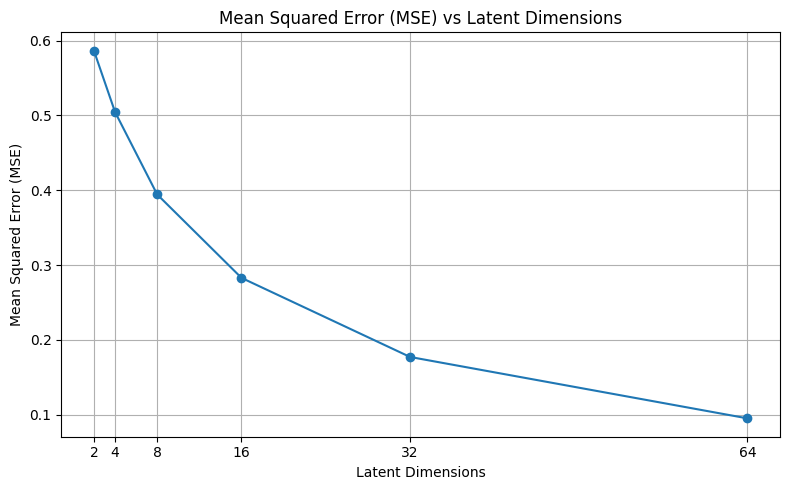

In [ ]:
latent_dims = list(mse_scores.keys())
mse_values = list(mse_scores.values())

# Plot the MSE graph
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mse_values, marker='o', linestyle='-')
plt.title('Mean Squared Error (MSE) vs Latent Dimensions')
plt.xlabel('Latent Dimensions')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.xticks(latent_dims)
plt.tight_layout()
plt.show()

## Part B: Probabilistic PCA

In [ ]:
def sample_latent(latent_dim,num_samples):
    mu = np.zeros(latent_dim)
    cov_matrix = np.eye(latent_dim)
    latent_samples = np.random.multivariate_normal(mu, cov_matrix, size=num_samples)
    return latent_samples

In [ ]:
class PPCA:
    def __init__(self, latent_dim, max_iter=100, tol=1e-6):
        self.latent_dim = latent_dim
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        N, D = X.shape
        self.mu = np.mean(X, axis=0)
        self.W = np.random.randn(D, self.latent_dim)
        self.sigma2 = 1.0

        for iter in range(self.max_iter):
            M = np.linalg.inv(np.eye(self.latent_dim) + self.W.T @ self.W / self.sigma2)
            Z = (X - self.mu) @ self.W @ M / self.sigma2

            self.W = (X - self.mu).T @ Z @ np.linalg.inv(Z.T @ Z + N * self.sigma2 * M)
            residuals = X - self.mu - Z @ self.W.T
            self.sigma2 = np.mean(np.sum(residuals ** 2, axis=1)) / D

            if iter > 0 and np.abs(prev_sigma2 - self.sigma2) < self.tol:
                break

            prev_sigma2 = self.sigma2

        return self


    def sample_latent(self, X):
        N = X.shape[0]
        M = np.linalg.inv(np.eye(self.latent_dim) + self.W.T @ self.W / self.sigma2)
        Z = (X - self.mu) @ self.W @ M / self.sigma2
        return Z

    def reconstruct(self, Z):
        return Z @ self.W.T + self.mu

In [ ]:
ppca_models = []
for latent_dim in tqdm(latent_dims, desc="Fitting PPCA models"):
    ppca = PPCA(latent_dim=latent_dim)
    ppca.fit(train_images_flat_std)
    ppca_models.append(ppca)

Fitting PPCA models: 100%|██████████| 6/6 [01:54<00:00, 19.00s/it]


In [ ]:
reconstructed_images_ppca = []
for ppca in tqdm(ppca_models, desc="Reconstructing test images"):
    Z_test = ppca.sample_latent(test_images_flat_std)
    reconstructed_image = ppca.reconstruct(Z_test)
    reconstructed_images_ppca.append(reconstructed_image)

Reconstructing test images: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]


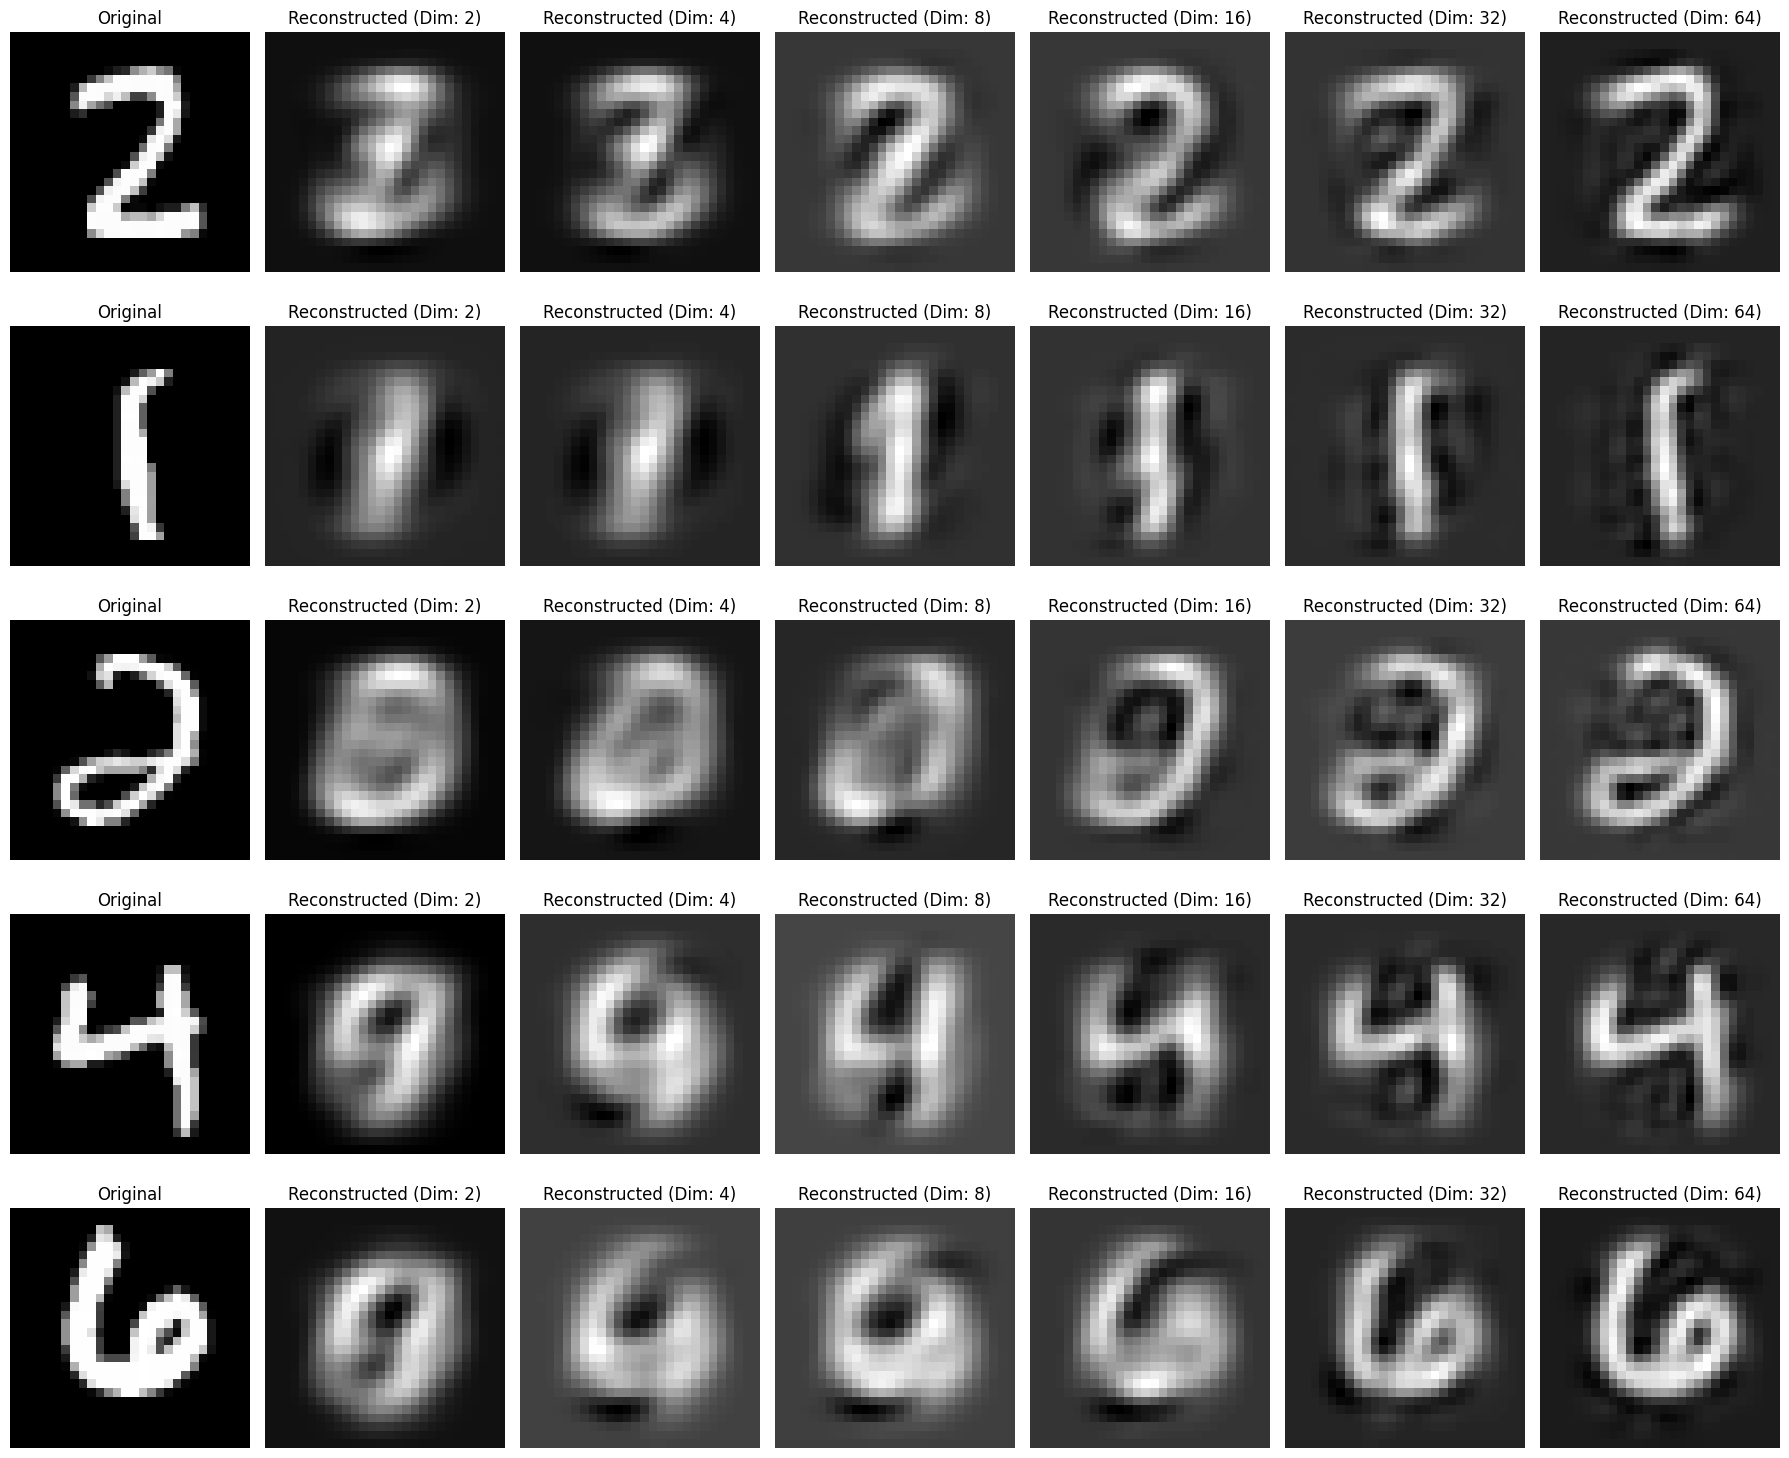

In [ ]:
num_samples = 5
num_models = len(latent_dims)

fig, axes = plt.subplots(num_samples, num_models + 1, figsize=(num_models * 3, num_samples * 3))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(test_images[idx].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j in range(num_models):
        axes[i, j + 1].imshow(reconstructed_images_ppca[j][idx].reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f'Reconstructed (Dim: {latent_dims[j]})')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mse_scores_ppca = {}
for latent_dim, reconstructed_image in zip(latent_dims, reconstructed_images_ppca):
    reconstructed_data = reconstructed_image.reshape(-1, 28*28)
    mse = np.mean((test_images_flat_std - reconstructed_data)**2)
    mse_scores_ppca[latent_dim] = mse

for latent_dim, mse in mse_scores_ppca.items():
    print(f"Latent Dimension: {latent_dim}, MSE: {mse}")

Latent Dimension: 2, MSE: 0.5864253169444344
Latent Dimension: 4, MSE: 0.5046036439382282
Latent Dimension: 8, MSE: 0.3945255565072412
Latent Dimension: 16, MSE: 0.28294251446357854
Latent Dimension: 32, MSE: 0.17727080463703687
Latent Dimension: 64, MSE: 0.09529802577383464


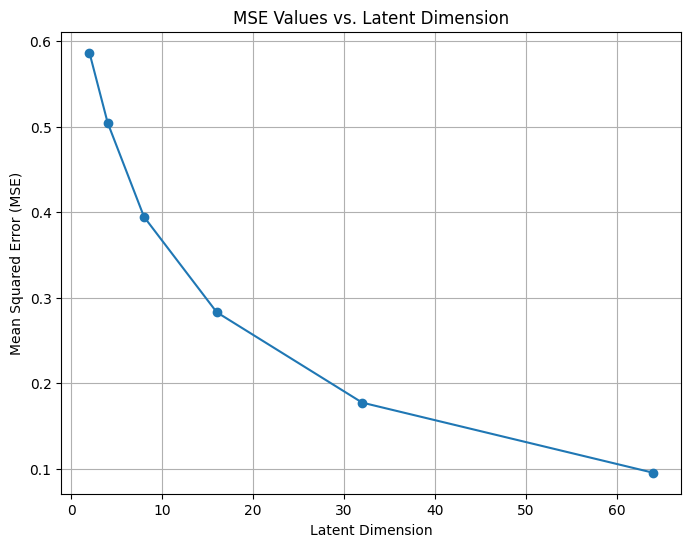

In [ ]:
latent_dims = list(mse_scores_ppca.keys())
mse_values = list(mse_scores_ppca.values())

plt.figure(figsize=(8, 6))
plt.plot(latent_dims, mse_values, marker='o', linestyle='-')
plt.xlabel('Latent Dimension')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Values vs. Latent Dimension')
plt.grid(True)
plt.show()

## Part C: Variational AutoEncoders

We need the images to retain their original shape for the convolutional layers to be applied and relevant in the VAE, so we reload the images.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

In [ ]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [ ]:
def build_vae(latent_dim):
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(decoder_input)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    output_img = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    # Define models
    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, output_img, name='decoder')
    vae_output = decoder(encoder(input_img)[2])
    vae = Model(input_img, vae_output, name='vae')

    # Define loss
    reconstruction_loss = mse(K.flatten(input_img), K.flatten(vae_output))
    reconstruction_loss *= 28 * 28
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae, encoder, decoder

In [ ]:
from tabulate import tabulate

def generate_architecture_table():
    architecture = [
        ["Layer", "Type", "Output Shape", "Param #"],
        ["Input", "Input", "(28, 28, 1)", "0"],
        ["Conv2D", "Convolutional", "(14, 14, 32)", "320"],
        ["Conv2D", "Convolutional", "(7, 7, 64)", "18496"],
        ["Flatten", "Flatten", "(7*7*64)", "0"],
        ["Dense (z_mean)", "Fully Connected", "(latent_dim)", "458880"],
        ["Dense (z_log_var)", "Fully Connected", "(latent_dim)", "458880"],
        ["Sampling", "Custom", "(latent_dim)", "0"],
        ["Decoder Input", "Input", "(latent_dim)", "0"],
        ["Dense", "Fully Connected", "(7*7*64)", "313600"],
        ["Reshape", "Reshape", "(7, 7, 64)", "0"],
        ["Conv2DT", "Transpose Convolutional", "(14, 14, 64)", "36928"],
        ["Conv2DT", "Transpose Convolutional", "(28, 28, 32)", "18464"],
        ["Conv2DT", "Transpose Convolutional", "(28, 28, 1)", "289"],
        ["Sigmoid", "Activation", "(28, 28, 1)", "0"],
        ["Output", "Output", "(28, 28, 1)", "0"]
    ]

    # Print the architecture table
    print(tabulate(architecture, headers="firstrow", tablefmt="fancy_grid"))

generate_architecture_table()


╒═══════════════════╤═════════════════════════╤════════════════╤═══════════╕
│ Layer             │ Type                    │ Output Shape   │   Param # │
╞═══════════════════╪═════════════════════════╪════════════════╪═══════════╡
│ Input             │ Input                   │ (28, 28, 1)    │         0 │
├───────────────────┼─────────────────────────┼────────────────┼───────────┤
│ Conv2D            │ Convolutional           │ (14, 14, 32)   │       320 │
├───────────────────┼─────────────────────────┼────────────────┼───────────┤
│ Conv2D            │ Convolutional           │ (7, 7, 64)     │     18496 │
├───────────────────┼─────────────────────────┼────────────────┼───────────┤
│ Flatten           │ Flatten                 │ (7*7*64)       │         0 │
├───────────────────┼─────────────────────────┼────────────────┼───────────┤
│ Dense (z_mean)    │ Fully Connected         │ (latent_dim)   │    458880 │
├───────────────────┼─────────────────────────┼────────────────┼───────────┤

In [ ]:
models = []
encoder_models = []
decoder_models = []

for latent_dim in latent_dims:
    vae, encoder, decoder = build_vae(latent_dim)
    vae.compile(optimizer='adam')
    vae.fit(train_images, epochs=10, batch_size=128)
    models.append(vae)
    encoder_models.append(encoder)
    decoder_models.append(decoder)

Epoch 1/10
469/469 [==============================] - 54s 113ms/step - loss: 54.4876
Epoch 2/10
469/469 [==============================] - 53s 113ms/step - loss: 44.5085
Epoch 3/10
469/469 [==============================] - 53s 113ms/step - loss: 42.8833
Epoch 4/10
469/469 [==============================] - 53s 114ms/step - loss: 42.1682
Epoch 5/10
469/469 [==============================] - 53s 112ms/step - loss: 41.7077
Epoch 6/10
469/469 [==============================] - 53s 113ms/step - loss: 41.3206
Epoch 7/10
469/469 [==============================] - 53s 113ms/step - loss: 40.9642
Epoch 8/10
469/469 [==============================] - 53s 113ms/step - loss: 40.6745
Epoch 9/10
469/469 [==============================] - 53s 113ms/step - loss: 40.4258
Epoch 10/10
469/469 [==============================] - 52s 112ms/step - loss: 40.2061
Epoch 1/10
469/469 [==============================] - 54s 114ms/step - loss: 53.4089
Epoch 2/10
469/469 [==============================] - 53s 114ms/

1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 14ms/step


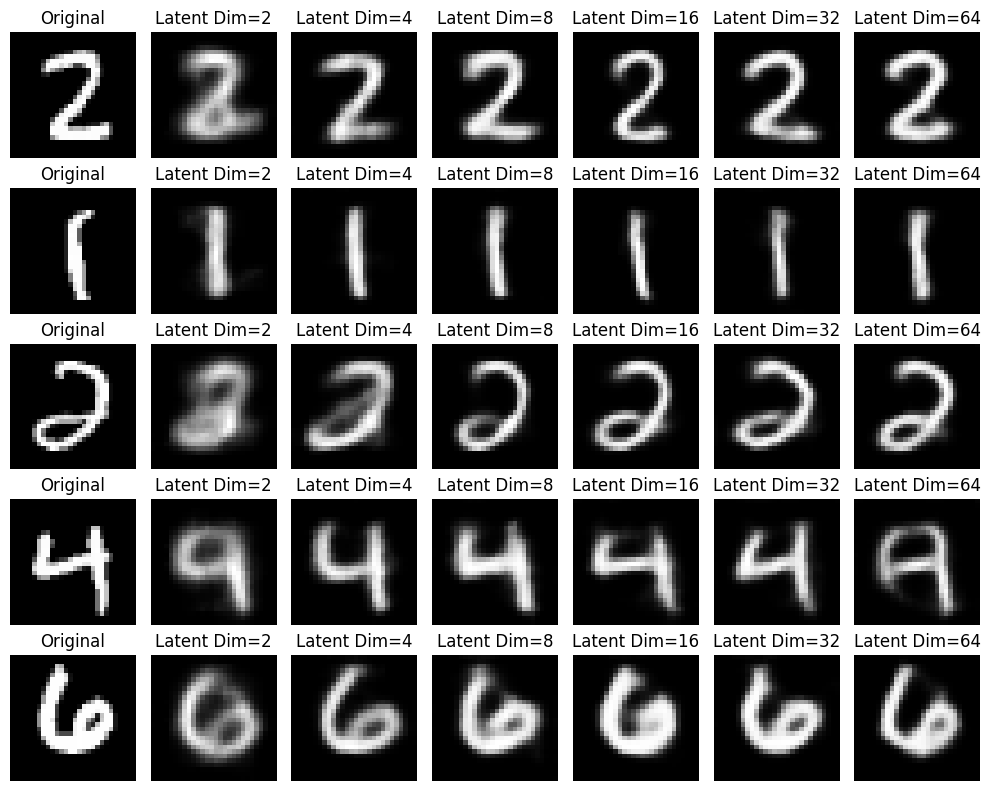

In [ ]:
num_images_to_display = 5
fig, axes = plt.subplots(num_images_to_display, len(models) + 1, figsize=(10, 8))

for i, idx in enumerate(random_indices):
    original_img = test_images[idx].reshape(28, 28)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    for j, model in enumerate(models):
        reconstructed_img = model.predict(test_images[idx].reshape(1, 28, 28, 1)).reshape(28, 28)
        axes[i, j+1].imshow(reconstructed_img, cmap='gray')
        axes[i, j+1].set_title(f'Latent Dim={latent_dims[j]}')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mse_values_VAE = []
for model in models:
    reconstructed_images = model.predict(test_images)
    mse_value = np.mean(np.square(test_images - reconstructed_images))
    mse_values_VAE.append(mse_value)

print(mse_values_VAE)

313/313 [==============================] - 3s 10ms/step
[0.045700524, 0.032508224, 0.02269275, 0.020034818, 0.02066718, 0.020832516]


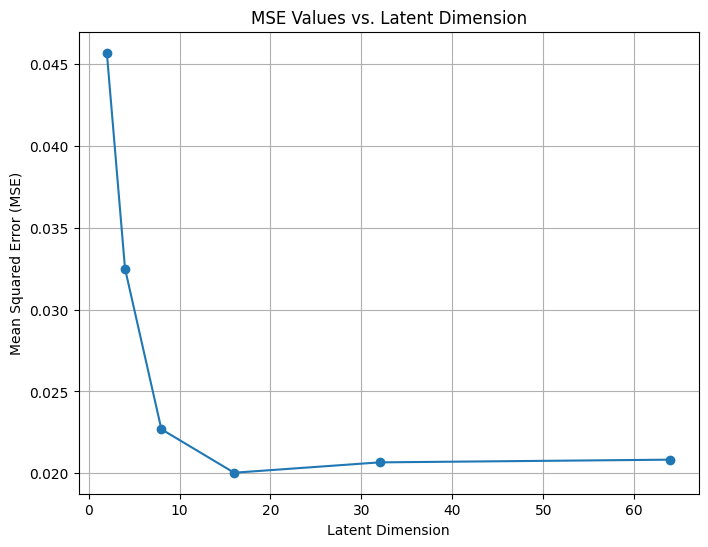

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(latent_dims, mse_values_VAE, marker='o', linestyle='-')
plt.xlabel('Latent Dimension')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Values vs. Latent Dimension')
plt.grid(True)
plt.show()

## Part D: Graph Plotting

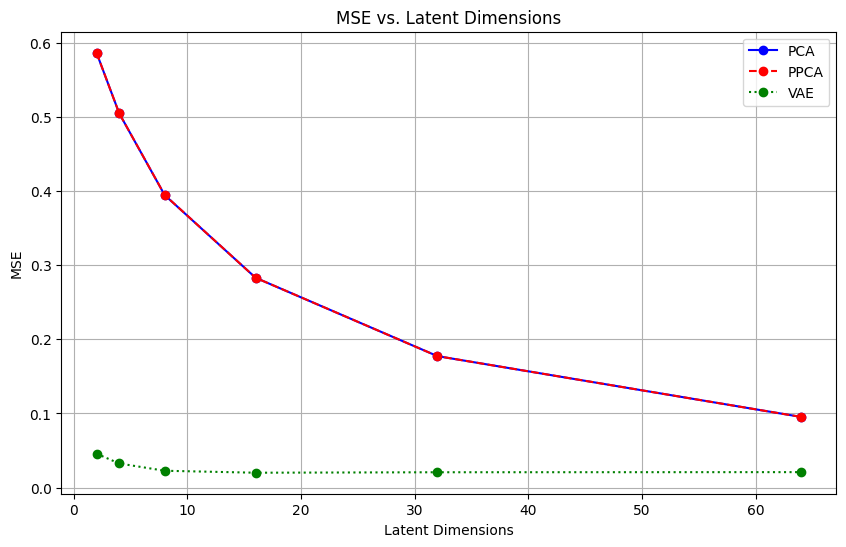

In [ ]:
# @title Default title text
latent_dims = list(mse_scores.keys())
plt.figure(figsize=(10, 6))

plt.plot(latent_dims, list(mse_scores.values()), label='PCA', marker='o', color='blue', linestyle='-')
plt.plot(latent_dims, list(mse_scores_ppca.values()), label='PPCA', marker='o', color='red', linestyle='--')
plt.plot(latent_dims, mse_values_VAE, label='VAE', marker='o', color='green', linestyle=':')

plt.title('MSE vs. Latent Dimensions')
plt.xlabel('Latent Dimensions')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()